# Effective feature engineering

Say, you have a model which takes 1 hour to train. Do you always need to wait for 1 hour to see the impact of a newly added feature?

> 比如说，你有一个模型需要1个小时的训练。您是否总是需要等待1个小时才能看到新添加特性的影响?

I talked with experienced Kaggers about feature engineering.
> 我与经验丰富的Kaggers讨论了特性工程。

They said that you get more accurate result when you check on the actual complex model you carefully built. But, it can be another risk if longer training time reduces the number of your trials.
> 他们说，当您仔细检查构建的实际复杂模型时，您将获得更准确的结果。 但是，如果更长的训练时间减少了试验次数，则可能会带来另一种风险。

**Traid-off: Accurate result <=> The number of trials**
> Traid-off:准确结果<=试验次数>

How they work on a competition is like below.

1. EDA
2. Build a simple model
3. Try various features on a simple model
4. Build a complex model
5. Train with promising features
> 1. EDA
> 2. 建立一个简单的模型
> 3. 在一个简单的模型上尝试各种特性
> 4. 建立一个复杂的模型
> 5. 有promising的培训

They go back and forth between steps during a competition. If you successfully setup an effective environment for experiments at the beginning of the competition, it puts you at an advantage.
> 在比赛中，他们在steps之间来回移动。如果你在比赛一开始就成功地建立了一个有效的实验环境，你就会处于有利地位。

I created a Kernel dedicated for feature engineering for this competition. I'd like to share what I've done so far.
> 我为这次竞赛创建了一个专门用于feature engineering的内核。我想分享一下我到目前为止所做的事情。

1. Correlation
2. Score gain on a simple model
3. Feature importances of Tree models
4. Permutation importance
5. SHAP values
6. Score gain on a complex model
> 1. Correlation
> 2. 在一个简单的模型上获得分数
> 3. 树模型的特征重要性
> 4. 排列重要性
> 5. SHAP 值
> 6. 在复杂模型上获得分数

The upper things are faster but less accurate and lower things are more accurate but slower. I'm trying from the top of the list when I come up with a new idea.

> 在上面的条目里，越往上的越精确，越快。越往下的条目越精确越慢。
> 当我想到一个新点子时，我就从列表的最上面开始尝试。

## 1. Correlation

This is the simplest way to see the relation between features. In here, if the value on the target is close to 0, it means that the feature may be irrelevant to the target.
> 这是看到特征间关系的最简单的方式，在这里，如果与target的corr value 越接近0，意味着feature与 target的相关性越低

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reload():
    gc.collect()
    df = pd.read_csv('../data/train_V2.csv')
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df

In [2]:
df = reload()

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 1017.83 MB
Memory usage after optimization is: 322.31 MB
Decreased by 68.3%


In [4]:
cols_to_drop = ['Id','groupId','matchId','matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

In [5]:
corr.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [6]:
corr.columns.values

array(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills',
       'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks',
       'longestKill', 'matchDuration', 'maxPlace', 'numGroups',
       'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'], dtype=object)

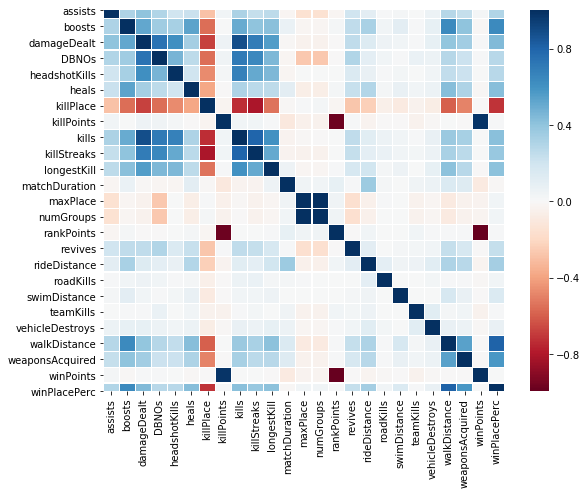

In [7]:
plt.figure(figsize=(9,7))
sns.heatmap(
    corr
    ,xticklabels=corr.columns.values
    ,yticklabels=corr.columns.values
    ,linecolor='white'
    ,linewidths=0.1
    ,cmap='RdBu'
)
plt.show()

In [8]:
agg = df.groupby(['groupId']).size().to_frame('players_in_team')
agg

,players_in_team
groupId,
00000c08b5be36,3
00000d1cbbc340,1
000025a09dd1d7,1
000038ec4dff53,3
00003a54230763,2
...,...
ffffedb6ecff6a,2
fffff305a0133d,2
fffff32bc7eab9,1


In [9]:
df = df.merge(agg,how='left',on=['groupId']) # 利用merge来将 groupId对应的players in team 数量合并到表中.
df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,players_in_team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446960,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,1292.000000,0,0.000000,0,0,1019.0000,3,1507,0.178589,5
4446961,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,0.000000,0,0.000000,0,0,81.6875,6,0,0.293457,1
4446962,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,0.000000,0,2.183594,0,0,788.5000,4,0,0.481445,3
4446963,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,0.000000,0,0.000000,0,0,2748.0000,8,0,0.799805,4


In [10]:
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0,inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0,inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf,0,inplace=True)

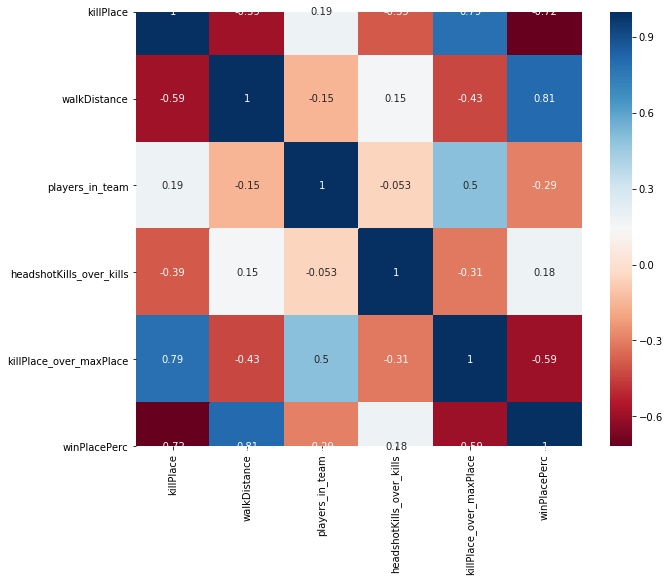

In [11]:
corr = df[[
    'killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills'
    , 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    #linecolor='white',
    #linewidths=0.1,
    cmap="RdBu"
)
plt.show()

Checking correlation is the fastest way to estimate the impact but it doesn't capture the actual contribution of the score. I will show an example in another Kernel.

> 检查相关性是估计影响的最快方法，但它并没有捕捉到分数的实际贡献。我将在另一个内核中展示一个示例。

## 2. Score gain on a simple model

I used LinearRegression during feature engineering since it's simple and fast. It'd be enough if you just want to see the impact of the new feature you added.
> 我在特征工程中使用了线性回归，因为它简单而快速。如果你只是想看看你添加的new feature的影响，这就足够了。

Aside from the main topic of this Kernel, it's better to split dataset by match since **we predict results by group in match**.
> 除了这个内核的主要主题之外，最好是根据 matchId 来分割数据集，因为我们以 group in match 来预测结果。

In [12]:
def train_test_split(df,test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids,train_size)
    
    train = df[df['matchId'].isin(train_match_ids)]# isin
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train,test

`run_experiments` method takes preprocess functions and returns DataFrame.

In [13]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):
    df = reload()
    df.drop(columns=['matchType'],inplace=True)
    
    df = preprocess(df)
    
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train, val = train_test_split(df, 0.1)
    
    model = LinearRegression()
    model.fit(train[cols_to_fit],train[target])
    
    y_true = val[target]
    y_pred = model.predict(val[cols_to_fit])
    return mean_absolute_error(y_true,y_pred)

In [14]:
def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time= time.time() - start
        results.append(
            {
                'name' : preprocess.__name__ # 函数对应的名称
                , 'score' : score # 所得分数
                , 'execution time' : f'{round(execution_time,2)}s' # 运行时间
            }
        )
        gc.collect()
        
        return pd.DataFrame(results,columns =['name','score','execution time']).sort_values(by='score')# list [map] 转换成dataframe

Let's see player-level generated features.

In [16]:
def original(df):
    return df

def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg,how='left',on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    # 爆头率
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    return df

def killPlace_over_maxPlace(df):
    # killPlace
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df


def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

In [17]:
run_experiments([
    original,
    items,
    players_in_team,
    total_distance,
    headshotKills_over_kills,
    killPlace_over_maxPlace,
    walkDistance_over_heals,
    walkDistance_over_kills,
    teamwork
])

,name,score,execution time
4,headshotKills_over_kills,0.091597,37.41s
2,players_in_team,0.091758,57.93s
5,killPlace_over_maxPlace,0.091949,40.96s
7,walkDistance_over_kills,0.092258,34.35s
6,walkDistance_over_heals,0.092284,31.2s
0,original,0.092412,76.67s
1,items,0.092491,41.71s
8,teamwork,0.092811,36.78s
3,total_distance,0.092974,32.32s


We can see the score and the execution time.

Next, let's see aggregated features.

In [29]:
agg.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'players_in_team', 'headshotKills_over_kills',
       'killPlace_over_maxPlace'],
      dtype='object')

In [18]:
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
features = [col for col in df.columns if col not in cols_to_drop] 
agg = df.groupby(['matchId','groupId'])[features].min() 
agg # 对matchId,groupId两个特征进行聚合操作，以这两个为基准，对其他的特征取最小值

assists  boosts  damageDealt  DBNOs  \
matchId        groupId                                               
0000a43bce5eec 18b16ec699d8b6        0       0    19.343750      0   
               236ab9e9c081b9        0       0     0.000000      0   
               3a6addfa0df938        0       0     0.000000      0   
               4bf06994bd4c9a        0       0     0.000000      0   
               4d1bbbc19b9084        1       3   151.750000      1   
...                                ...     ...          ...    ...   
fffe92232706aa b671eab579d429        0       0    16.953125      0   
               bd5b4ecf8067ab        0       2     4.628906      0   
               c8e95cc6c06d41        0       0     0.000000      0   
               d57f3a3ed40913        0       0     0.000000      0   
               d8fa9cfd6f9560        0       0     0.000000      0   

                               headshotKills  heals  killPlace  killPoints  \
matchId        groupId                                                       
0000a43bce5eec 18b16ec699d8b6              0      0         21        1065   
               236ab9e9c081b9              0      0         88        1244   
               3a6addfa0df938              0      0         94        1306   
               4bf06994bd4c9a              0      0         59        1167   
               4d1bbbc19b9084              1      0          5        1308   
...                                      ...    ...        ...         ...   
fffe92232706aa b671eab579d429              0      0         29           0   
               bd5b4ecf8067ab              0      3         13           0   
               c8e95cc6c06d41              0      0         37           0   
               d57f3a3ed40913              0      0         33           0   
               d8fa9cfd6f9560              0      0         19           0   

                               kills  killStreaks  ...  roadKills  \
matchId        groupId                             ...              
0000a43bce5eec 18b16ec699d8b6      0            0  ...          0   
               236ab9e9c081b9      0            0  ...          0   
               3a6addfa0df938      0            0  ...          0   
               4bf06994bd4c9a      0            0  ...          0   
               4d1bbbc19b9084      1            1  ...          0   
...                              ...          ...  ...        ...   
fffe92232706aa b671eab579d429      1            1  ...          0   
               bd5b4ecf8067ab      1            1  ...          0   
               c8e95cc6c06d41      0            0  ...          0   
               d57f3a3ed40913      0            0  ...          0   
               d8fa9cfd6f9560      0            0  ...          0   

                               swimDistance teamKills  vehicleDestroys  \
matchId        groupId                                                   
0000a43bce5eec 18b16ec699d8b6      0.000000         0                0   
               236ab9e9c081b9      0.000000         0                0   
               3a6addfa0df938      0.000000         0                0   
               4bf06994bd4c9a      0.000000         0                0   
               4d1bbbc19b9084      4.605469         0                0   
...                                     ...       ...              ...   
fffe92232706aa b671eab579d429      0.000000         0                0   
               bd5b4ecf8067ab      0.000000         0                0   
               c8e95cc6c06d41      0.000000         0                0   
               d57f3a3ed40913      0.000000         0                0   
               d8fa9cfd6f9560      0.000000         0                0   

                               walkDistance  weaponsAcquired  winPoints  \
matchId        groupId                                                    
0000a43bce5eec 18b16ec699d8b6        74.000                1       1474   
               236a

In [19]:
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

In [20]:
run_experiments([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

,name,score,execution time
6,rank_by_team,0.057723,108.33s
4,median_by_team,0.076096,80.89s
5,mean_by_team,0.077007,84.53s
2,max_by_team,0.079271,91.04s
3,sum_by_team,0.087832,90.71s
1,min_by_team,0.089905,102.62s
0,original,0.092175,44.07s


You can see how important rank features are in this competition.

## 3. Feature importances of Tree models

Tree models can output feature importances.

/Users/helloword/Develop/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


[20]	valid_0's l1: 0.0648813
[40]	valid_0's l1: 0.0616004
[60]	valid_0's l1: 0.0604218
[80]	valid_0's l1: 0.0597163
[100]	valid_0's l1: 0.0593012


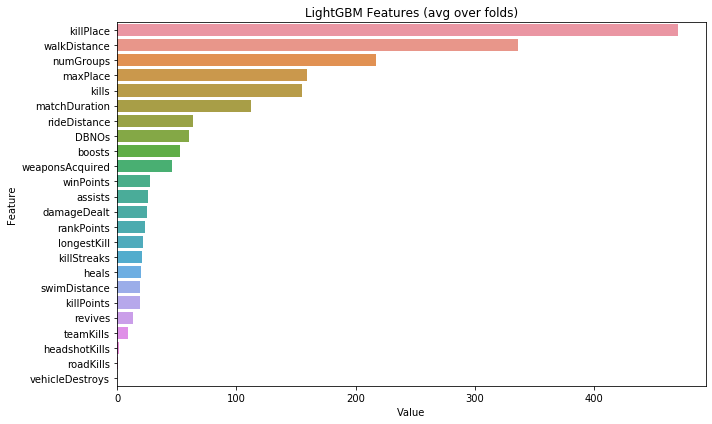

In [21]:
df = reload()

# Option 1: Give it as category
# df['matchType'] = df['matchType'].astype('category')
# Option 2: pd.dummies
# df = pd.concat([df, pd.get_dummies(df['matchType'])], axis=1)
# Option 3: Drop it for now (Not the best solution)
df.drop(columns=['matchType'], inplace=True)

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)

from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

There are several options for measuring importance like "split" (How many times the feature is used to split), "gain" (The average training loss reduction gained when using a feature for splitting).
> 在划分特征时所用的特征，和用哪些特征划分的时候损失函数值变小了

However, sometimes it doesn't represent the actual contribution.
> 虽然有时候这并不代表真正的贡献

<img src="https://cdn-images-1.medium.com/max/1600/1*UEQiHKTnjHJ-swIjcAkRnA.png" width="640">

To our dismay we see that the feature importance orderings are very different for each of the three options provided by XGBoost! For the cover method it seems like the capital gain feature is most predictive of income, while for the gain method the relationship status feature dominates all the others. This should make us very uncomfortable about relying on these measures for reporting feature importance without knowing which method is best.
> 令我们沮丧的是，我们看到XGBoost提供的三个选项的重要特性排序非常不同!
> 对于覆盖法来说，capital gain feature 似乎是对收入的最具预测性的，而对于收益法来说，relationship status 特征是最主要的。
> 这应该让我们对依赖这些meatures 来报告feature 重要性而不知道哪种方法是最好的感到非常不舒服。

<div align="center">
    <a href="https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27">Interpretable Machine Learning with XGBoost</a>
</div>

This is the background of Interpretable machine learning which is a field receiving a lot of attention recently. You can find papers and libraries here: [lopusz/awesome-interpretable-machine-learning](https://github.com/lopusz/awesome-interpretable-machine-learning)

## 4. Permutation importance

The basic idea is that observing how much the score decreases when a feature is not available; the method is known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

> 其基本思想是观察当某个特性不可用时，得分下降了多少;该方法被称为“排列重要性”或“平均降低准确性(MDA)”。

In [23]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(val[cols_to_fit], val[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

Weight,Feature
1.4651 ± 0.0048,killPlace
0.2952 ± 0.0010,walkDistance
0.2298 ± 0.0010,kills
0.0780 ± 0.0003,numGroups
0.0597 ± 0.0004,killStreaks
0.0544 ± 0.0002,maxPlace
0.0285 ± 0.0003,matchDuration
0.0076 ± 0.0001,boosts
0.0071 ± 0.0001,rideDistance
0.0038 ± 0.0001,weaponsAcquired


The figure shows the importance of each feature. ELI5 shuffles the target feature instead of removing it to make it useless so that we don't need to re-train the model again. That's why it's represented like `± 0.0033` (standard deviation).
> 图中显示了每个feature的重要性。ELI5对目标特性进行了shuffles，而不是删除它make it useless，这样我们就不需要重新训练模型了。这就是为什么它表示为±0.0033(标准差)

Removing a feature and see the difference... this is what I was doing above, but more reliable! However, there is room to discuss how to define/measure contribution.
> 删除一个feature，看看有什么不同…这就是我在上面所做的，但是更可靠!但是，还有讨论如何定义/度量贡献的空间。

## 5. SHAP values

SHAP proposed a new fair way to measure contribution which is justified in game theory.
> SHAP提出了一种新的衡量贡献的公平方法，并在博弈论中得到了验证。

[A Unified Approach to Interpreting Model
Predictions](https://arxiv.org/pdf/1705.07874.pdf) (2017)

Understanding why a model makes a certain prediction can be as crucial as the prediction’s accuracy in many applications. However, the highest accuracy for large modern datasets is often achieved by complex models that even experts struggle to interpret, such as ensemble or deep learning models, creating a tension between accuracy and interpretability.

> 在许多应用中，理解为什么一个模型做出某种预测与预测的准确性同样重要。
> 然而，对于大型现代数据集来说，最高的准确性往往是通过复杂的模型来实现的，即使是专家也很难解释这些模型，比如集成或深度学习模型，这在准确性和可解释性之间制造了一种tension。

Simple models are easy to interpret. They built a simple model which works well only on a local point (We don't need to predict on the all points). Then, use the simple model to interpret how it's trained.
> 简单的模型很容易解释。他们建立了一个简单的模型，只在局部点上运行良好(我们不需要预测所有的点)。然后，使用简单的模型来解释它是如何被训练的。

<img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png" width="420">

This method was proposed in this paper: [“Why Should I Trust You?”
Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf) (2016, known as LIME)

The main contribution of SHAP is that they introduced the concept of Shapley Value to measure the contribution.
> SHAP的主要贡献是他们引入了Shapley值的概念来衡量贡献。

Shapley Value is a solution concept in cooperative game theory, proposed in 1953 by [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley).
> Shapley值是合作博弈论中的一个解概念，由1953年提出

- Question: What is a "fair" way for a colition to divide its payoff?
> 什么是一种“公平”的方式来分配它的收益?
  - Depends on the definition of "fairness"
  > 取决于“公平”的定义
- Approach: Identify axioms that express properties of a fair payoff division
> 方法:确定表示公平回报分配的性质的公理
  - Symmetry: Interchangeable agents should receive the same payments
  > 对称:可互换的 agents 应收到相同的回报
  - Dummy Players: Dummy players should receive nothing
  > dummy玩家 : dummy玩家应该什么都得不到
  - Additivity: $$(v_1 + v_2)(S) = v_1(S) + v_2(S)$$

The author of SHAP found that we can apply this concept to machine learning. In machine learning, *player* is *feature*, and *contribution* is *score*.
> SHAP的作者发现我们可以将这个概念应用到机器学习中。在机器学习中，*player*是*feature*， *contribution*是*score*。

For example, we have 3 features L, M, and N. The shapley values are calculated like below.
> 例如，我们有3个特征L、M和n。shapley值的计算如下所示。

<img src="https://cdn-images-1.medium.com/max/1600/1*DLL5sCQKeVXboAYIvdgwUw.png" width="640">
<img src="https://cdn-images-1.medium.com/max/1600/1*uGjQRe9U0ebC5HxYXAzg3A.png" width="420">

It's the average of combinations of features. Intuitively, it sounds fair.
> It's the average of combinations of features. Intuitively, it sounds fair.

The implementation is available on GitHub: [slundberg/shap: A unified approach to explain the output of any machine learning model](https://github.com/slundberg/shap)

In [24]:
import shap
shap.initjs()

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val[cols_to_fit])

SHAP values represent the fair score of features depending on their contribution towards the total score in the set of features.

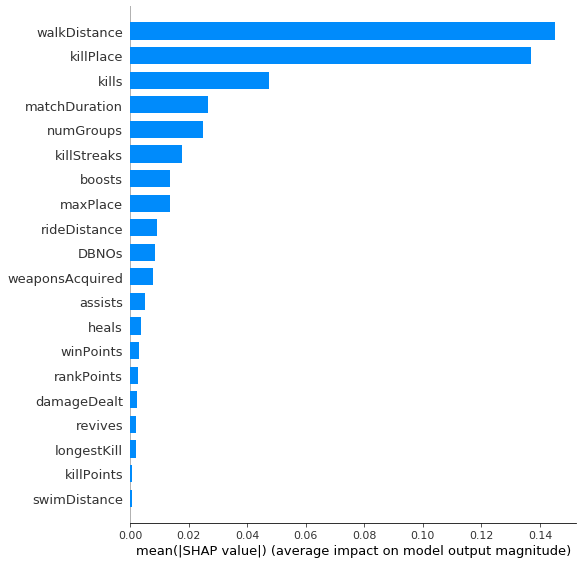

In [26]:
shap.summary_plot(shap_values, val[cols_to_fit], plot_type='bar')

SHAP also can visualize how the score changes when the feature value is low/high on each data.

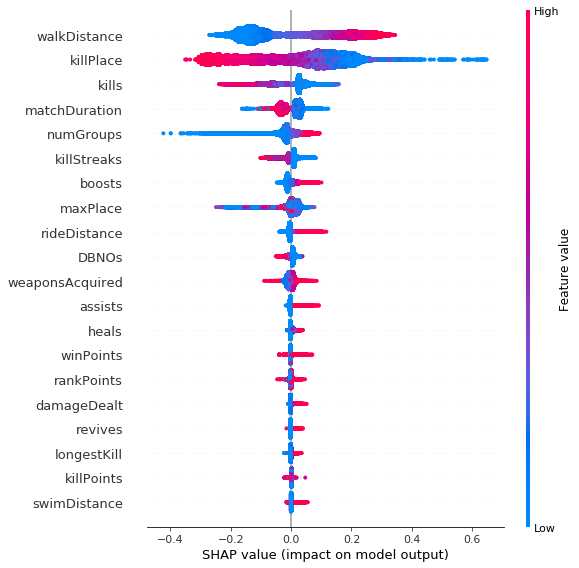

In [27]:
shap.summary_plot(shap_values, val[cols_to_fit], feature_names=cols_to_fit)

## 6. Score gain on a complex model

Checking on the real model. After selecting important features, I start looking at the actual impact on a complex model.

---

So, what should we do? It depends on the requirement and there is a trade-off but I'd recommend to build an environment to try new ideas quickly and fail quickly! You'd earn new ideas through the process.

Thank you for reading this Kernel. I'm still new to this field. I'd like to hear how you work on feature engineering.